# Bayesian Multilevel Modelling using PyStan

Folowing through Chris Fonnesbeck's primer on using PyStan with Bayesian Multilevel Modelling.

* *Multilevel model*: a regression model in which constituent model parameters are given probability models, which implies that they caa vary by group. These are generalisations of regression modelling.
* *Hierarchical model*: a multilevel model where parameters are nested within one another.

## Example: Radon contamination

Radon is a radioactive gas that enters homes through contact points with the ground. The EPA conducted a study of radon levels in 80,000 houses. There were two important predictors:

* measurement in the basement, or ground floor (radon expected to be higher in basements)
* county uranium level (correlates positively with radon level)

We will model radon levels in a single state: Minnesota. The hierarchy in this example is households, which exist within counties.

In [1]:
%pylab inline

import numpy as np
import pandas as pd
import seaborn as sns; sns.set_context('notebook')

Populating the interactive namespace from numpy and matplotlib


In [3]:
# Import radon data
srrs2 = pd.read_csv('data/srrs2.dat')
srrs2.columns = srrs2.columns.map(str.strip)

# Make a combined state and county ID, by household
srrs_mn = srrs2.assign(fips=srrs2.stfips * 1000 + srrs2.cntyfips)[srrs2.state == 'MN']

In [6]:
# Check data
srrs_mn.head()

,idnum,state,state2,stfips,zip,region,typebldg,floor,room,basement,...,startdt,stopdt,activity,pcterr,adjwt,dupflag,zipflag,cntyfips,county,fips
5080,5081,MN,MN,27,55735,5,1,1,3,N,...,12088,12288,2.2,9.7,1146.499190,1,0,1,AITKIN,27001
5081,5082,MN,MN,27,55748,5,1,0,4,Y,...,11888,12088,2.2,14.5,471.366223,0,0,1,AITKIN,27001
5082,5083,MN,MN,27,55748,5,1,0,4,Y,...,20288,21188,2.9,9.6,433.316718,0,0,1,AITKIN,27001
5083,5084,MN,MN,27,56469,5,1,0,4,Y,...,122987,123187,1.0,24.3,461.623670,0,0,1,AITKIN,27001
5084,5085,MN,MN,27,55011,3,1,0,4,Y,...,12888,13088,3.1,13.8,433.316718,0,0,3,ANOKA,27003


In [7]:
# Obtain the uranium level as a county-level predictor
cty = pd.read_csv('data/cty.dat')
cty_mn = cty[cty.st == 'MN'].copy()  # MN only data

# Make a combined state and county id, by county
cty_mn['fips'] = 1000 * cty_mn.stfips + cty_mn.ctfips

In [8]:
# Check data
cty_mn.head()

,stfips,ctfips,st,cty,lon,lat,Uppm,fips
1326,27,1,MN,AITKIN,-93.415,46.608,0.502054,27001
1327,27,3,MN,ANOKA,-93.246,45.273,0.428565,27003
1328,27,5,MN,BECKER,-95.674,46.935,0.892741,27005
1329,27,7,MN,BELTRAMI,-94.937,47.974,0.552472,27007
1330,27,9,MN,BENTON,-93.998,45.699,0.866849,27009


In [9]:
# Combine data into a single dataframe
srrs_mn = srrs_mn.merge(cty_mn[['fips', 'Uppm']], on='fips')  # Get uranium level by household (on county basis)
srrs_mn = srrs_mn.drop_duplicates(subset='idnum')  # Lose duplicate houses
u = np.log(srrs_mn.Uppm)  # log-transform uranium level
n = len(srrs_mn)  # number of households

In [10]:
# Check data
srrs_mn.head()

,idnum,state,state2,stfips,zip,region,typebldg,floor,room,basement,...,stopdt,activity,pcterr,adjwt,dupflag,zipflag,cntyfips,county,fips,Uppm
0,5081,MN,MN,27,55735,5,1,1,3,N,...,12288,2.2,9.7,1146.499190,1,0,1,AITKIN,27001,0.502054
1,5082,MN,MN,27,55748,5,1,0,4,Y,...,12088,2.2,14.5,471.366223,0,0,1,AITKIN,27001,0.502054
2,5083,MN,MN,27,55748,5,1,0,4,Y,...,21188,2.9,9.6,433.316718,0,0,1,AITKIN,27001,0.502054
3,5084,MN,MN,27,56469,5,1,0,4,Y,...,123187,1.0,24.3,461.623670,0,0,1,AITKIN,27001,0.502054
4,5085,MN,MN,27,55011,3,1,0,4,Y,...,13088,3.1,13.8,433.316718,0,0,3,ANOKA,27003,0.428565


In [14]:
# Index counties with a lookup dictionary
srrs_mn.county = srrs_mn.county.str.strip()
mn_counties = srrs_mn.county.unique()
counties = len(mn_counties)
county_lookup = dict(zip(mn_counties, range(len(mn_counties))))

In [17]:
# Make local copies of variables
county = srrs_mn['county_code'] = srrs_mn.county.replace(county_lookup).values
radon = srrs_mn.activity
srrs_mn['log_radon'] = log_radon = np.log(radon + 0.1).values
floor_measure = srrs_mn.floor.values

## Distribution of radon in MN

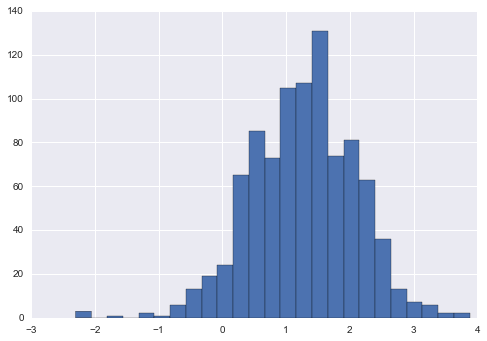

In [23]:
srrs_mn.activity.apply(lambda x: np.log(x + 0.1)).hist(bins=25)

## Conventional approaches

Two conventional alternatives to modelling represent two extremes of the tradeoff between variance and bias. Taking $y = \log(\textrm{radon})$, floor measurements (basement or ground) as $x$, where $i$ indicates the house, and $j[i]$ is the county to which a house 'belongs'. Then $\alpha$ is the radon level across all counties, and $\alpha_{j[i]}$ is the radon level in a single county; $\beta$ is the influence of the choice of floor at which measurement is made; and $\epsilon$ is some other error (measurement error, temporal variation in a house, or variation among houses).

* **Complete pooling** - treat all counties the same, and estimate a single radon level: $y_i = \alpha + \beta x_i + \epsilon_i$
* **No pooling** - treat each county independently: $y_i = \alpha_{j[i]} + \beta x_i + \epsilon_i$

### Specifying the pooled model in Stan

We construct the data block, comprising vectors of log-radon measurements (`y`) and floor measurement covariates (`x`), as well as the number of samples (`N`)

In [27]:
# Construct the data block.
pooled_data = """
data {
  int<lower=0> N;
  vector[N] x;
  vector[N] y;
}
"""

Next we initialise parameters, which here are linear model coefficients (`beta`) that are assumed to lie on a Normal distribution, and the Normal distribution scale parameter `sigma`, which is constrained to be positive.

In [28]:
# Initialise parameters
pooled_parameters = """
parameters {
    vector[2] beta;
    real<lower=0> sigma;
}
"""

Finally we specify the model, with log(radon) measurements as a normal sample, having a mean that is a function of the choice of floor at which the measurement was made, $y \sim N(\beta[1] + \beta[2]x)$

In [29]:
pooled_model = """
model {
  y ~ normal(beta[1] + beta[2] * x, sigma);
}
"""

### Running the pooled model in Stan

First we map the Python variables to those in the `stan` model. Then we pass the data, parameters and model to `stan`. We need to specify how many iterations of sampling we want, and how many parallel chains to sample (here, 1000 iterations of 2 chains).

In [30]:
import pystan

pooled_data_dict = {'N': len(log_radon),
                    'x': floor_measure,
                    'y': log_radon}

pooled_fit = pystan.stan(model_code=pooled_data + pooled_parameters + pooled_model,
                         data=pooled_data_dict,
                         iter=1000,
                         chains=2)

Once the fit has been run, the sample can be extracted for visualisation and summarisation:

In [31]:
# Collect the sample
pooled_sample = pooled_fit.extract(permuted=True)

In [37]:
# Get mean values for parameters, from the sample
# b0 = common radon value across counties
# m0 = variation in radon level with change in floor
b0, m0 = pooled_sample['beta'].T.mean(1)

In [34]:
b0, m0

(1.3633879413102479, -0.58813286904951934)

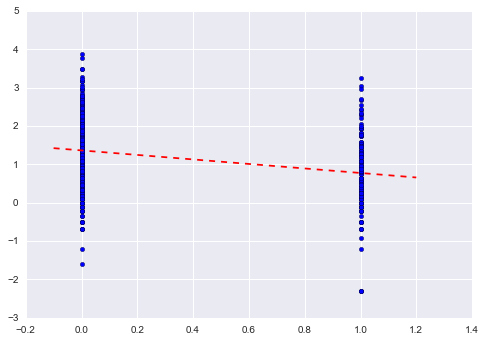

In [38]:
# Plot the fitted model (red line) against observed values (blue points)
plt.scatter(srrs_mn.floor, np.log(srrs_mn.activity + 0.1))
xvals = np.linspace(-0.1, 1.2)
plt.plot(xvals, m0 * xvals + b0, 'r--')